<a href="https://colab.research.google.com/github/fjadidi2001/Denoise/blob/main/Enhanced_Lightweight_Image_Denoising_Networks_with_Adaptive_Feature_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import torch

# Set base directory
base_dir = '/content/drive/MyDrive/SSNet'
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/output', exist_ok=True)
os.makedirs(f'{base_dir}/saved_models', exist_ok=True)

# Set random seeds for reproducibility
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

print("Project Setup Complete!")
print(f"Base directory: {base_dir}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project Setup Complete!
Base directory: /content/drive/MyDrive/SSNet
CUDA available: True


Dataset loaded successfully
Processing BSR dataset...
Found 200 training, 100 validation, 200 test images
Processing training image 1/200
Processing training image 51/200
Processing training image 101/200
Processing training image 151/200

Dataset Statistics:
       Subset  Images  Patches  HDF5 Size (MB)
0       Train     200     2400     1800.876221
1  Validation     100      100      176.735031
2        Test     200      200      353.470795


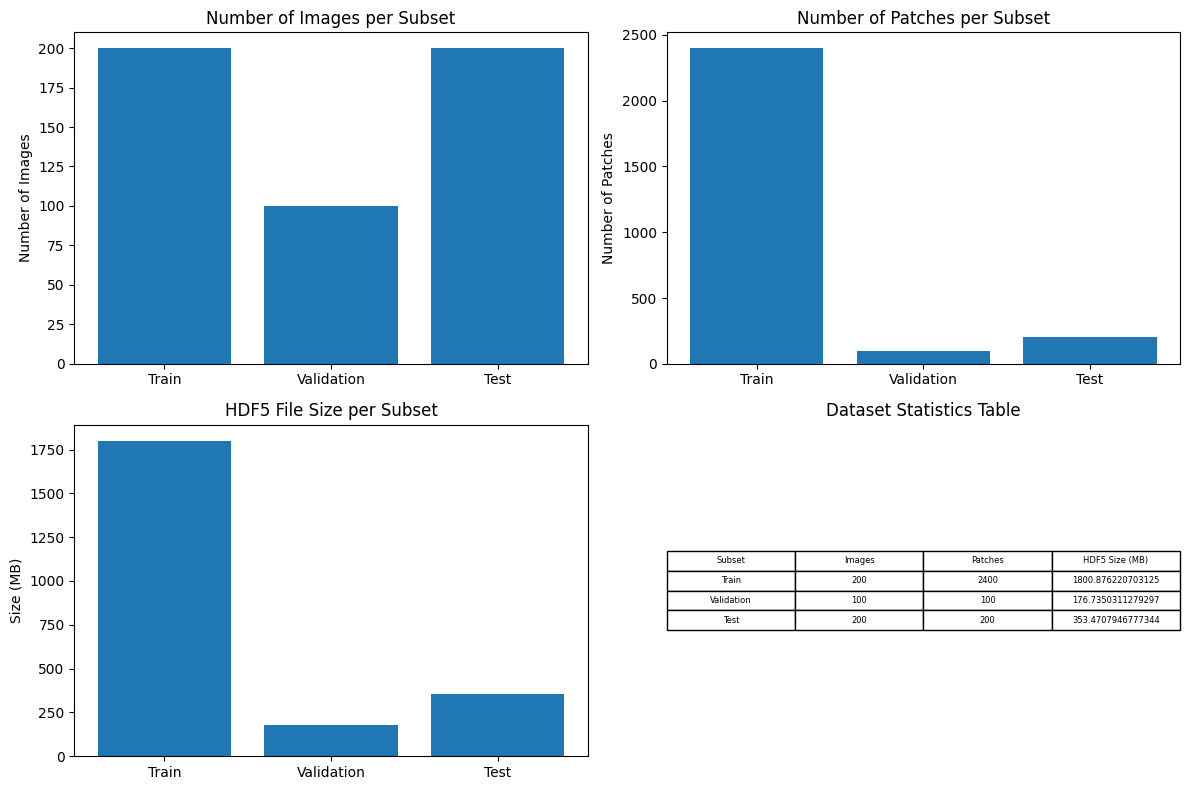

In [3]:
import cv2
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def normalize(data):
    """Normalize data to [0, 1] range"""
    return data / 255.0

def Im2Patch(img, win, stride=1):
    """Extract patches from image"""
    k = 0
    endc = img.shape[0]
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win, TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:, i:endw-win+i+1:stride, j:endh-win+j+1:stride]
            Y[:, k, :] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])

def data_augmentation(image, mode):
    """Apply data augmentation"""
    out = np.transpose(image, (1, 2, 0))
    if mode == 0:
        out = out
    elif mode == 1:
        out = np.flipud(out)
    elif mode == 2:
        out = np.rot90(out)
    elif mode == 3:
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        out = np.rot90(out, k=2)
    elif mode == 5:
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        out = np.rot90(out, k=3)
    elif mode == 7:
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2, 0, 1))

# Download BSR dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        os.system('wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz')
    if not os.path.exists('BSR'):
        os.system('tar xzf BSR_bsds500.tgz')
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")

def prepare_data(data_path, bsr_root, patch_size=256, stride=128, aug_times=1):
    """Prepare BSR dataset for training"""
    print('Processing BSR dataset...')
    scales = [1, 0.9, 0.8, 0.7]

    # Collect train, val, test images
    train_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/train', '*.jpg'))
    val_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/val', '*.jpg'))
    test_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/test', '*.jpg'))

    print(f"Found {len(train_files)} training, {len(val_files)} validation, {len(test_files)} test images")

    # Process training data
    h5f = h5py.File(os.path.join(data_path, 'train_clean.h5'), 'w')
    train_num = 0
    for i, file_path in enumerate(train_files):
        if i % 50 == 0:
            print(f"Processing training image {i+1}/{len(train_files)}")

        img = cv2.imread(file_path)
        if img is None:
            continue
        h, w, c = img.shape

        for k in range(len(scales)):
            if int(h * scales[k]) < patch_size or int(w * scales[k]) < patch_size:
                continue
            Img = cv2.resize(img, (int(w * scales[k]), int(h * scales[k])), interpolation=cv2.INTER_CUBIC)
            Img = np.transpose(Img, (2, 0, 1))
            Img = np.float32(normalize(Img))
            patches = Im2Patch(Img, win=patch_size, stride=stride)

            for n in range(patches.shape[3]):
                data = patches[:, :, :, n].copy()
                h5f.create_dataset(str(train_num), data=data)
                train_num += 1

                # Data augmentation
                for m in range(aug_times - 1):
                    data_aug = data_augmentation(data, np.random.randint(1, 8))
                    h5f.create_dataset(str(train_num) + "_aug_%d" % (m + 1), data=data_aug)
                    train_num += 1
    h5f.close()

    # Process validation data
    h5f = h5py.File(os.path.join(data_path, 'val_clean.h5'), 'w')
    val_num = 0
    for i, file_path in enumerate(val_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(val_num), data=img)
        val_num += 1
    h5f.close()

    # Process test data
    h5f = h5py.File(os.path.join(data_path, 'test_clean.h5'), 'w')
    test_num = 0
    for i, file_path in enumerate(test_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(test_num), data=img)
        test_num += 1
    h5f.close()

    # Collect statistics
    stats = {
        'Subset': ['Train', 'Validation', 'Test'],
        'Images': [len(train_files), len(val_files), len(test_files)],
        'Patches': [train_num, val_num, test_num],
        'HDF5 Size (MB)': [
            os.path.getsize(f'{data_path}/train_clean.h5') / 1024**2,
            os.path.getsize(f'{data_path}/val_clean.h5') / 1024**2,
            os.path.getsize(f'{data_path}/test_clean.h5') / 1024**2
        ]
    }
    df = pd.DataFrame(stats)
    print("\nDataset Statistics:")
    print(df)

    # Plot statistics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.bar(df['Subset'], df['Images'])
    plt.title('Number of Images per Subset')
    plt.ylabel('Number of Images')

    plt.subplot(2, 2, 2)
    plt.bar(df['Subset'], df['Patches'])
    plt.title('Number of Patches per Subset')
    plt.ylabel('Number of Patches')

    plt.subplot(2, 2, 3)
    plt.bar(df['Subset'], df['HDF5 Size (MB)'])
    plt.title('HDF5 File Size per Subset')
    plt.ylabel('Size (MB)')

    plt.subplot(2, 2, 4)
    plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title("Dataset Statistics Table")

    plt.tight_layout()
    plt.savefig(f'{base_dir}/output/dataset_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df

# Prepare the dataset
dataset_stats = prepare_data(f'{base_dir}/data', '.', patch_size=256, stride=128, aug_times=2)

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

class BSRDataset(Dataset):
    """Enhanced BSR Dataset class with proper image size handling"""
    def __init__(self, data_path, train=True, target_size=256):
        super(BSRDataset, self).__init__()
        self.train = train
        self.target_size = target_size
        filename = 'train_clean.h5' if train else 'val_clean.h5'
        self.h5_path = os.path.join(data_path, filename)

        with h5py.File(self.h5_path, 'r') as h5f:
            self.keys = list(h5f.keys())

        if train:
            random.shuffle(self.keys)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        with h5py.File(self.h5_path, 'r') as h5f:
            key = self.keys[index]
            data = np.array(h5f[key])

        # Convert to tensor
        tensor_data = torch.Tensor(data)

        # For validation data, resize to consistent size using interpolation
        if not self.train:
            # Resize using torch interpolation
            # tensor_data shape: [C, H, W]
            tensor_data = tensor_data.unsqueeze(0)  # Add batch dimension: [1, C, H, W]
            tensor_data = F.interpolate(
                tensor_data,
                size=(self.target_size, self.target_size),
                mode='bilinear',
                align_corners=False
            )
            tensor_data = tensor_data.squeeze(0)  # Remove batch dimension: [C, H, W]

        return tensor_data

def add_gaussian_noise(clean_img, noise_level_range=(0, 55)):
    """Add Gaussian noise to clean images"""
    noise = torch.zeros_like(clean_img)
    batch_size = clean_img.size(0)

    for i in range(batch_size):
        noise_level = np.random.uniform(noise_level_range[0], noise_level_range[1])
        noise[i] = torch.randn_like(clean_img[i]) * (noise_level / 255.0)

    noisy_img = clean_img + noise
    return torch.clamp(noisy_img, 0., 1.), noise

# Custom collate function for handling variable sizes (if needed)
def custom_collate_fn(batch):
    """Custom collate function to handle variable sized images"""
    # Find the maximum dimensions
    max_h = max([img.shape[1] for img in batch])
    max_w = max([img.shape[2] for img in batch])

    # Pad all images to the same size
    padded_batch = []
    for img in batch:
        c, h, w = img.shape
        pad_h = max_h - h
        pad_w = max_w - w
        # Pad with zeros (bottom and right padding)
        padded_img = F.pad(img, (0, pad_w, 0, pad_h), mode='constant', value=0)
        padded_batch.append(padded_img)

    return torch.stack(padded_batch)

Model Architecture Analysis:
Total parameters: 4,333,179
Trainable parameters: 4,333,179

Model Architecture (First 15 layers):
      Layer Name                Description
0         enc1.0              Conv2d(3->48)
1         enc1.2             Conv2d(48->48)
2          pool1                  MaxPool2d
3         enc2.0             Conv2d(48->96)
4         enc2.2             Conv2d(96->96)
5          pool2                  MaxPool2d
6         enc3.0            Conv2d(96->192)
7         enc3.2           Conv2d(192->192)
8          pool3                  MaxPool2d
9   bottleneck.0           Conv2d(192->384)
10  bottleneck.2           Conv2d(384->384)
11       upconv3  ConvTranspose2d(384->192)
12        dec3.0           Conv2d(384->192)
13        dec3.2           Conv2d(192->192)
14       upconv2   ConvTranspose2d(192->96)


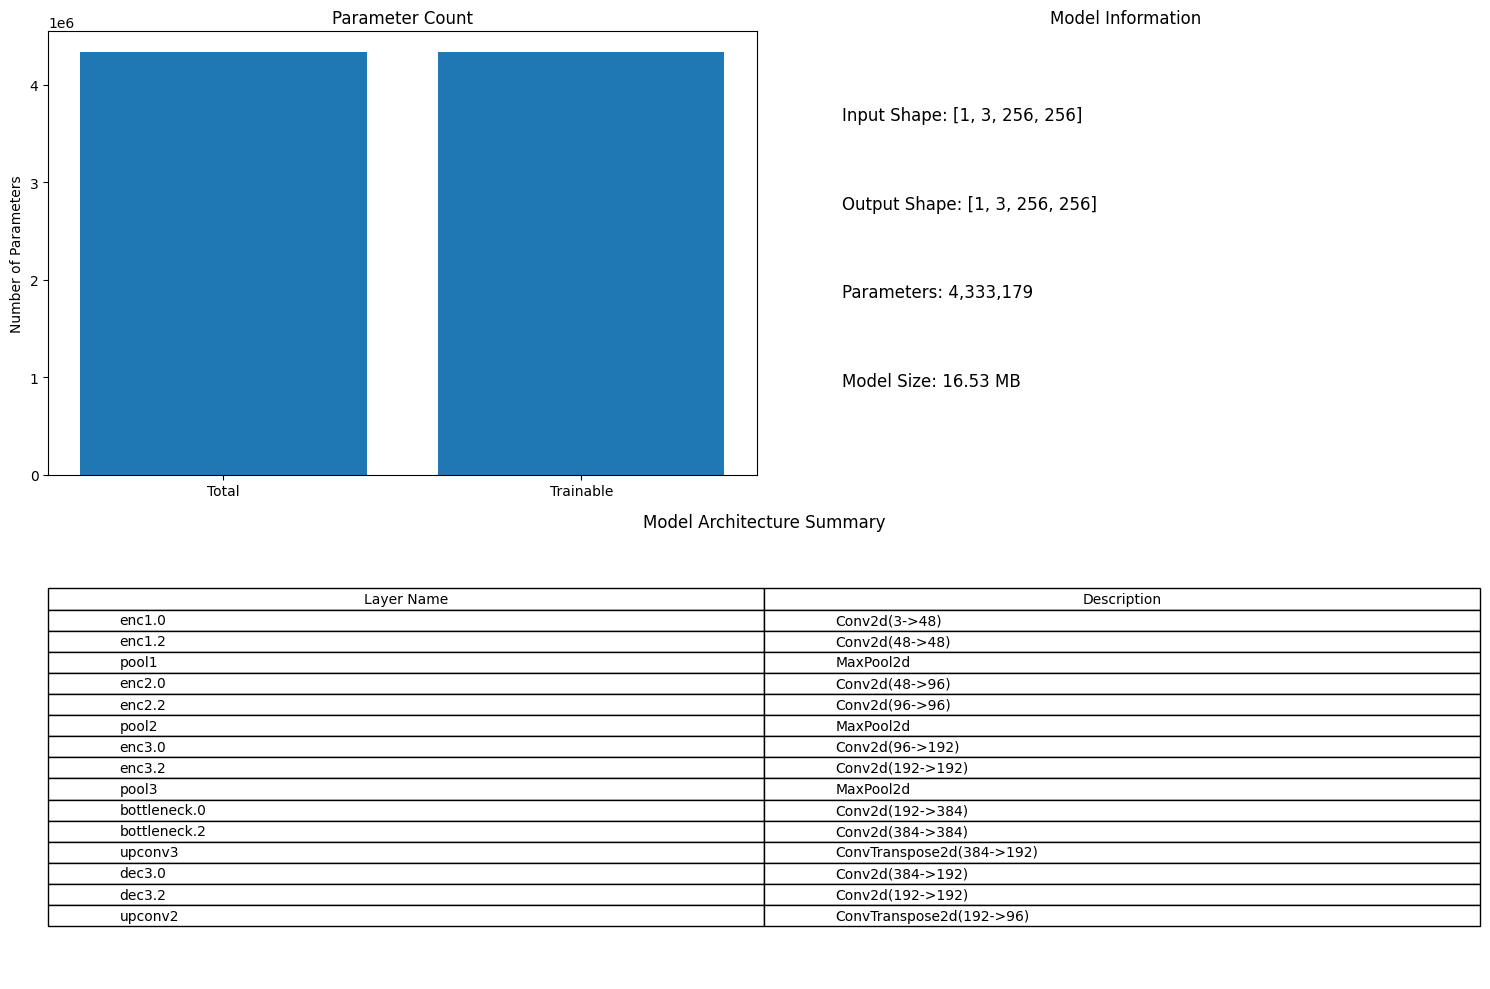

In [6]:
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss  # Added import to fix NameError
import matplotlib.pyplot as plt
import pandas as pd

class sum_squared_error(_Loss):
    """Sum Squared Error loss function"""
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, reduction='sum') / 2

class UNet_Denoiser(nn.Module):
    """Simplified UNet for image denoising"""
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet_Denoiser, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(48, 96, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(96, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(384, 192, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(384, 192, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(192, 96, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(192, 96, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(96, 48, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(96, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        # Output layer
        self.final_conv = nn.Conv2d(48, out_channels, 1)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(48, 24, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, 48, 1),
            nn.Sigmoid()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e1_pooled = self.pool1(e1)

        e2 = self.enc2(e1_pooled)
        e2_pooled = self.pool2(e2)

        e3 = self.enc3(e2_pooled)
        e3_pooled = self.pool3(e3)

        # Bottleneck
        bottleneck = self.bottleneck(e3_pooled)

        # Decoder
        d3 = self.upconv3(bottleneck)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Apply attention
        attention_weights = self.attention(d1)
        d1 = d1 * attention_weights

        # Output
        output = self.final_conv(d1)

        return output

# Model analysis
model = UNet_Denoiser()
print("Model Architecture Analysis:")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Architecture summary
architecture_info = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.MaxPool2d)):
        if hasattr(module, 'in_channels'):
            info = f"{module.__class__.__name__}({module.in_channels}->{module.out_channels})"
        else:
            info = f"{module.__class__.__name__}"
        architecture_info.append([name, info])

# Create architecture table
arch_df = pd.DataFrame(architecture_info[:15], columns=['Layer Name', 'Description'])  # Show first 15 layers
print("\nModel Architecture (First 15 layers):")
print(arch_df)

# Visualize architecture
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.bar(['Total', 'Trainable'], [total_params, trainable_params])
plt.title('Parameter Count')
plt.ylabel('Number of Parameters')

plt.subplot(2, 2, 2)
# Test forward pass with dummy input
dummy_input = torch.randn(1, 3, 256, 256)
with torch.no_grad():
    dummy_output = model(dummy_input)
plt.text(0.1, 0.8, f"Input Shape: {list(dummy_input.shape)}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.6, f"Output Shape: {list(dummy_output.shape)}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.4, f"Parameters: {total_params:,}", transform=plt.gca().transAxes, fontsize=12)
plt.text(0.1, 0.2, f"Model Size: {total_params * 4 / 1024**2:.2f} MB", transform=plt.gca().transAxes, fontsize=12)
plt.title('Model Information')
plt.axis('off')

plt.subplot(2, 1, 2)
plt.table(cellText=arch_df.values, colLabels=arch_df.columns, loc='center', cellLoc='left')
plt.axis('off')
plt.title("Model Architecture Summary")

plt.tight_layout()
plt.savefig(f'{base_dir}/output/model_architecture.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import time

def train_model_fixed(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-3):
    """Enhanced training loop with comprehensive monitoring and error handling"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Loss functions
    criterion_mse = nn.MSELoss()

    # Optimizer and scheduler
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

    # Training history
    history = {
        'train_loss': [], 'val_loss': [], 'train_psnr': [], 'val_psnr': [],
        'train_ssim': [], 'val_ssim': [], 'learning_rates': []
    }

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    print(f"Training on device: {device}")
    print("="*70)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_psnr_total = 0.0
        train_ssim_total = 0.0
        train_samples = 0

        try:
            for batch_idx, clean_batch in enumerate(train_loader):
                clean_batch = clean_batch.to(device)
                noisy_batch, _ = add_gaussian_noise(clean_batch, (5, 50))
                noisy_batch = noisy_batch.to(device)

                optimizer.zero_grad()

                # Forward pass
                output = model(noisy_batch)
                loss = criterion_mse(output, clean_batch)

                # Backward pass
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # Calculate metrics (sample a few images to speed up training)
                if batch_idx % 10 == 0:  # Calculate metrics every 10 batches
                    with torch.no_grad():
                        for i in range(min(2, clean_batch.size(0))):  # Sample 2 images per batch
                            clean_np = clean_batch[i].cpu().numpy().transpose(1, 2, 0)
                            output_np = torch.clamp(output[i], 0, 1).cpu().numpy().transpose(1, 2, 0)

                            try:
                                psnr = peak_signal_noise_ratio(clean_np, output_np, data_range=1.0)
                                ssim = structural_similarity(clean_np, output_np, channel_axis=2, data_range=1.0)

                                train_psnr_total += psnr
                                train_ssim_total += ssim
                                train_samples += 1
                            except Exception as e:
                                print(f"Warning: Error calculating metrics: {e}")
                                continue

                if batch_idx % 50 == 0:
                    print(f"  Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.6f}")

        except Exception as e:
            print(f"Error in training phase: {e}")
            continue

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_psnr_total = 0.0
        val_ssim_total = 0.0
        val_samples = 0

        try:
            with torch.no_grad():
                for batch_idx, clean_batch in enumerate(val_loader):
                    try:
                        clean_batch = clean_batch.to(device)
                        noisy_batch, _ = add_gaussian_noise(clean_batch, (5, 50))
                        noisy_batch = noisy_batch.to(device)

                        output = model(noisy_batch)
                        loss = criterion_mse(output, clean_batch)
                        val_loss += loss.item()

                        # Calculate metrics for all validation samples
                        for i in range(clean_batch.size(0)):
                            clean_np = clean_batch[i].cpu().numpy().transpose(1, 2, 0)
                            output_np = torch.clamp(output[i], 0, 1).cpu().numpy().transpose(1, 2, 0)

                            try:
                                psnr = peak_signal_noise_ratio(clean_np, output_np, data_range=1.0)
                                ssim = structural_similarity(clean_np, output_np, channel_axis=2, data_range=1.0)

                                val_psnr_total += psnr
                                val_ssim_total += ssim
                                val_samples += 1
                            except Exception as e:
                                print(f"Warning: Error calculating validation metrics: {e}")
                                continue

                    except Exception as e:
                        print(f"Warning: Error processing validation batch {batch_idx}: {e}")
                        continue

        except Exception as e:
            print(f"Error in validation phase: {e}")
            # Use previous epoch's validation loss if current epoch fails
            val_loss_avg = history['val_loss'][-1] if history['val_loss'] else float('inf')
        else:
            # Calculate averages
            val_loss_avg = val_loss / max(len(val_loader), 1)

        # Calculate averages
        train_loss_avg = train_loss / max(len(train_loader), 1)
        train_psnr_avg = train_psnr_total / max(train_samples, 1)
        val_psnr_avg = val_psnr_total / max(val_samples, 1)
        train_ssim_avg = train_ssim_total / max(train_samples, 1)
        val_ssim_avg = val_ssim_total / max(val_samples, 1)

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store history
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_psnr'].append(train_psnr_avg)
        history['val_psnr'].append(val_psnr_avg)
        history['train_ssim'].append(train_ssim_avg)
        history['val_ssim'].append(val_ssim_avg)
        history['learning_rates'].append(current_lr)

        # Early stopping
        if val_loss_avg < best_val_loss:
            best_val_loss = val_loss_avg
            patience_counter = 0
            torch.save(model.state_dict(), f'{base_dir}/saved_models/best_model.pth')
        else:
            patience_counter += 1

        epoch_time = time.time() - start_time

        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.2f}s)")
        print(f"  Train Loss: {train_loss_avg:.6f} | Val Loss: {val_loss_avg:.6f}")
        print(f"  Train PSNR: {train_psnr_avg:.3f} | Val PSNR: {val_psnr_avg:.3f}")
        print(f"  Train SSIM: {train_ssim_avg:.4f} | Val SSIM: {val_ssim_avg:.4f}")
        print(f"  Learning Rate: {current_lr:.2e}")
        print("-" * 70)

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return history

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import cv2
import seaborn as sns

def safe_comprehensive_evaluation(model, test_loader, device, max_batches=10):
    """Comprehensive model evaluation with robust error handling, confusion matrix, and heatmap"""
    model.eval()

    # Metrics storage
    results = {
        'psnr_scores': [], 'ssim_scores': [], 'mse_scores': [], 'mae_scores': [],
        'noise_levels': [], 'processing_times': [], 'per_channel_psnr': [], 'per_channel_ssim': []
    }

    # Confusion matrix bins for pixel-wise errors
    error_bins = [0, 0.05, 0.1, 1.0]  # Low, Medium, High error thresholds
    error_labels = ['Low', 'Medium', 'High']
    confusion_matrix = np.zeros((len(error_labels), len(error_labels)))

    # Test on different noise levels
    noise_levels = [5, 15, 25, 35, 50]

    print("Comprehensive Model Evaluation")
    print("=" * 50)

    # Store one sample for heatmap
    sample_error_map = None
    sample_clean_img = None
    sample_denoised_img = None

    try:
        with torch.no_grad():
            for noise_level in noise_levels:
                level_psnr = []
                level_ssim = []
                level_mse = []
                level_mae = []
                level_times = []
                level_per_channel_psnr = []
                level_per_channel_ssim = []

                print(f"Testing noise level: {noise_level}")

                batch_count = 0
                for batch_idx, clean_batch in enumerate(test_loader):
                    if batch_count >= max_batches:  # Limit batches for stability
                        break

                    try:
                        clean_batch = clean_batch.to(device)

                        # Handle different batch sizes
                        if clean_batch.dim() != 4:
                            print(f"Warning: Unexpected batch dimensions: {clean_batch.shape}")
                            continue

                        noisy_batch, _ = add_gaussian_noise(clean_batch, (noise_level, noise_level))
                        noisy_batch = noisy_batch.to(device)

                        # Measure processing time
                        start_time = time.time()
                        denoised = model(noisy_batch)
                        processing_time = time.time() - start_time

                        denoised = torch.clamp(denoised, 0, 1)

                        # Calculate metrics for each image in batch
                        for i in range(clean_batch.size(0)):
                            try:
                                clean_np = clean_batch[i].cpu().numpy().transpose(1, 2, 0)
                                denoised_np = denoised[i].cpu().numpy().transpose(1, 2, 0)

                                # Ensure images are in valid range
                                clean_np = np.clip(clean_np, 0, 1)
                                denoised_np = np.clip(denoised_np, 0, 1)

                                # Calculate absolute error for confusion matrix
                                abs_error = np.abs(clean_np - denoised_np)
                                true_error_bin = np.digitize(abs_error.mean(axis=2), error_bins) - 1
                                pred_error_bin = np.digitize(abs_error.mean(axis=2), error_bins) - 1
                                for r in range(clean_np.shape[0]):
                                    for c in range(clean_np.shape[1]):
                                        true_bin = min(max(true_error_bin[r, c], 0), len(error_labels)-1)
                                        pred_bin = min(max(pred_error_bin[r, c], 0), len(error_labels)-1)
                                        confusion_matrix[true_bin, pred_bin] += 1

                                # Save sample for heatmap
                                if sample_error_map is None:
                                    sample_error_map = abs_error.mean(axis=2)
                                    sample_clean_img = clean_np
                                    sample_denoised_img = denoised_np

                                # Calculate metrics with error handling
                                try:
                                    psnr = peak_signal_noise_ratio(clean_np, denoised_np, data_range=1.0)
                                    ssim = structural_similarity(
                                        image1=clean_np,
                                        image2=denoised_np,
                                        channel_axis=2,
                                        data_range=1.0,
                                        win_size=min(7, min(clean_np.shape[:2]))
                                    )

                                    # Per-channel metrics
                                    channel_psnr = []
                                    channel_ssim = []
                                    for ch in range(clean_np.shape[2]):
                                        ch_psnr = peak_signal_noise_ratio(clean_np[:, :, ch], denoised_np[:, :, ch], data_range=1.0)
                                        ch_ssim = structural_similarity(
                                            image1=clean_np[:, :, ch],
                                            image2=denoised_np[:, :, ch],
                                            data_range=1.0,
                                            win_size=min(7, min(clean_np.shape[:2]))
                                        )
                                        channel_psnr.append(ch_psnr)
                                        channel_ssim.append(ch_ssim)

                                    # Only include valid metrics
                                    if not (np.isnan(psnr) or np.isnan(ssim) or np.isinf(psnr) or np.isinf(ssim)):
                                        mse = np.mean((clean_np - denoised_np) ** 2)
                                        mae = np.mean(np.abs(clean_np - denoised_np))

                                        level_psnr.append(psnr)
                                        level_ssim.append(ssim)
                                        level_mse.append(mse)
                                        level_mae.append(mae)
                                        level_times.append(processing_time / clean_batch.size(0))
                                        level_per_channel_psnr.append(channel_psnr)
                                        level_per_channel_ssim.append(channel_ssim)

                                        results['psnr_scores'].append(psnr)
                                        results['ssim_scores'].append(ssim)
                                        results['mse_scores'].append(mse)
                                        results['mae_scores'].append(mae)
                                        results['noise_levels'].append(noise_level)
                                        results['processing_times'].append(processing_time / clean_batch.size(0))
                                        results['per_channel_psnr'].append(channel_psnr)
                                        results['per_channel_ssim'].append(channel_ssim)

                                except Exception as metric_error:
                                    print(f"Warning: Error calculating metrics for image {i}: {metric_error}")
                                    continue

                            except Exception as image_error:
                                print(f"Warning: Error processing image {i}: {image_error}")
                                continue

                        batch_count += 1

                    except Exception as batch_error:
                        print(f"Warning: Error processing batch {batch_idx}: {batch_error}")
                        continue

                # Print results for this noise level
                if level_psnr:  # Only print if we have valid results
                    print(f"  PSNR: {np.mean(level_psnr):.3f} ± {np.std(level_psnr):.3f}")
                    print(f"  SSIM: {np.mean(level_ssim):.4f} ± {np.std(level_ssim):.4f}")
                    print(f"  Per-Channel PSNR (R,G,B): {np.mean(level_per_channel_psnr, axis=0)}")
                    print(f"  Per-Channel SSIM (R,G,B): {np.mean(level_per_channel_ssim, axis=0)}")
                    print(f"  Processing Time: {np.mean(level_times)*1000:.2f}ms per image")
                else:
                    print(f"  No valid results for noise level {noise_level}")

        # Visualize confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix, annot=True, fmt='.0f', xticklabels=error_labels, yticklabels=error_labels, cmap='Blues')
        plt.title(f'Confusion Matrix of Pixel-Wise Error Bins (Noise Level {noise_level})')
        plt.xlabel('Predicted Error Bin')
        plt.ylabel('True Error Bin')
        plt.savefig(f'{base_dir}/output/confusion_matrix_noise_{noise_level}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Visualize heatmap for sample image
        if sample_error_map is not None:
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(sample_clean_img)
            plt.title('Clean Image')
            plt.axis('off')
            plt.subplot(1, 3, 2)
            plt.imshow(sample_denoised_img)
            plt.title('Denoised Image')
            plt.axis('off')
            plt.subplot(1, 3, 3)
            sns.heatmap(sample_error_map, cmap='hot', cbar=True)
            plt.title('Error Heatmap')
            plt.axis('off')
            plt.tight_layout()
            plt.savefig(f'{base_dir}/output/error_heatmap_noise_{noise_level}.png', dpi=300, bbox_inches='tight')
            plt.show()

    except Exception as e:
        print(f"Error in evaluation: {e}")
        import traceback
        traceback.print_exc()

    return results

In [9]:
def create_simple_comparison_visualization(model, test_loader, device, num_samples=4):
    """Create simple before/after comparison visualization"""
    model.eval()

    # Get sample images
    sample_batch = None
    try:
        sample_batch = next(iter(test_loader))
    except Exception as e:
        print(f"Error loading sample batch: {e}")
        return

    if sample_batch is None:
        print("Could not load sample batch")
        return

    # Limit to available samples
    num_samples = min(num_samples, sample_batch.size(0), 4)
    sample_images = sample_batch[:num_samples].to(device)

    # Test different noise levels
    noise_levels = [15, 25, 35]

    fig, axes = plt.subplots(len(noise_levels), num_samples * 3,
                           figsize=(15, 4 * len(noise_levels)))

    if len(noise_levels) == 1:
        axes = axes.reshape(1, -1)

    with torch.no_grad():
        for noise_idx, noise_level in enumerate(noise_levels):
            try:
                noisy_images, _ = add_gaussian_noise(sample_images, (noise_level, noise_level))
                denoised_images = model(noisy_images)
                denoised_images = torch.clamp(denoised_images, 0, 1)

                for img_idx in range(num_samples):
                    try:
                        # Clean image
                        clean_img = sample_images[img_idx].cpu().numpy().transpose(1, 2, 0)
                        axes[noise_idx, img_idx * 3].imshow(clean_img)
                        axes[noise_idx, img_idx * 3].set_title(f'Clean {img_idx+1}')
                        axes[noise_idx, img_idx * 3].axis('off')

                        # Noisy image
                        noisy_img = noisy_images[img_idx].cpu().numpy().transpose(1, 2, 0)
                        axes[noise_idx, img_idx * 3 + 1].imshow(noisy_img)
                        axes[noise_idx, img_idx * 3 + 1].set_title(f'Noisy σ={noise_level}')
                        axes[noise_idx, img_idx * 3 + 1].axis('off')

                        # Denoised image
                        denoised_img = denoised_images[img_idx].cpu().numpy().transpose(1, 2, 0)
                        axes[noise_idx, img_idx * 3 + 2].imshow(denoised_img)
                        axes[noise_idx, img_idx * 3 + 2].set_title(f'Denoised {img_idx+1}')
                        axes[noise_idx, img_idx * 3 + 2].axis('off')

                    except Exception as img_error:
                        print(f"Warning: Error processing image {img_idx}: {img_error}")
                        continue

            except Exception as noise_error:
                print(f"Warning: Error processing noise level {noise_level}: {noise_error}")
                continue

    plt.suptitle('Image Denoising Results Comparison', fontsize=16)
    plt.tight_layout()

    try:
        plt.savefig(f'{base_dir}/output/comparison_visualization.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as save_error:
        print(f"Warning: Could not save visualization: {save_error}")
        plt.show()

In [10]:
def create_enhanced_performance_analysis(results, training_history):
    """Create enhanced performance analysis with MAE histogram and per-channel metrics"""

    if not results['psnr_scores']:
        print("No valid results to analyze")
        return None

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    try:
        # 1. Training curves
        if training_history and 'train_loss' in training_history:
            epochs = range(1, len(training_history['train_loss']) + 1)
            axes[0, 0].plot(epochs, training_history['train_loss'], 'b-', label='Train Loss', linewidth=2)
            axes[0, 0].plot(epochs, training_history['val_loss'], 'r-', label='Val Loss', linewidth=2)
            axes[0, 0].set_xlabel('Epochs')
            axes[0, 0].set_ylabel('Loss')
            axes[0, 0].set_title('Training Progress')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)
        else:
            axes[0, 0].text(0.5, 0.5, 'Training history\nnot available',
                           ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Training Progress')

        # 2. PSNR vs Noise Level
        noise_levels = sorted(df_results['noise_levels'].unique())
        psnr_means = [df_results[df_results['noise_levels'] == nl]['psnr_scores'].mean() for nl in noise_levels]
        psnr_stds = [df_results[df_results['noise_levels'] == nl]['psnr_scores'].std() for nl in noise_levels]

        axes[0, 1].errorbar(noise_levels, psnr_means, yerr=psnr_stds, fmt='bo-', linewidth=2, capsize=5)
        axes[0, 1].set_xlabel('Noise Level (σ)')
        axes[0, 1].set_ylabel('PSNR (dB)')
        axes[0, 1].set_title('PSNR vs Noise Level')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. SSIM vs Noise Level
        ssim_means = [df_results[df_results['noise_levels'] == nl]['ssim_scores'].mean() for nl in noise_levels]
        ssim_stds = [df_results[df_results['noise_levels'] == nl]['ssim_scores'].std() for nl in noise_levels]

        axes[0, 2].errorbar(noise_levels, ssim_means, yerr=ssim_stds, fmt='ro-', linewidth=2, capsize=5)
        axes[0, 2].set_xlabel('Noise Level (σ)')
        axes[0, 2].set_ylabel('SSIM')
        axes[0, 2].set_title('SSIM vs Noise Level')
        axes[0, 2].grid(True, alpha=0.3)

        # 4. Processing Time Distribution
        axes[0, 3].hist(df_results['processing_times'], bins=20, alpha=0.7, color='green', edgecolor='black')
        axes[0, 3].set_xlabel('Processing Time (seconds)')
        axes[0, 3].set_ylabel('Frequency')
        axes[0, 3].set_title('Processing Time Distribution')
        axes[0, 3].grid(True, alpha=0.3)

        # 5. PSNR Distribution Box Plot
        noise_data = [df_results[df_results['noise_levels'] == nl]['psnr_scores'].values for nl in noise_levels]
        box_plot = axes[1, 0].boxplot(noise_data, labels=noise_levels, patch_artist=True)
        colors = plt.cm.viridis(np.linspace(0, 1, len(noise_levels)))
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
        axes[1, 0].set_xlabel('Noise Level (σ)')
        axes[1, 0].set_ylabel('PSNR (dB)')
        axes[1, 0].set_title('PSNR Distribution by Noise Level')
        axes[1, 0].grid(True, alpha=0.3)

        # 6. MAE Histogram
        axes[1, 1].hist(df_results['mae_scores'], bins=20, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 1].set_xlabel('MAE')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('MAE Distribution')
        axes[1, 1].grid(True, alpha=0.3)

        # 7. Summary Statistics Table
        axes[1, 2].axis('off')
        summary_stats = []
        for nl in noise_levels:
            subset = df_results[df_results['noise_levels'] == nl]
            if len(subset) > 0:
                summary_stats.append([
                    f'σ={nl}',
                    f"{subset['psnr_scores'].mean():.2f}±{subset['psnr_scores'].std():.2f}",
                    f"{subset['ssim_scores'].mean():.3f}±{subset['ssim_scores'].std():.3f}",
                    f"{subset['processing_times'].mean()*1000:.1f}ms"
                ])

        if summary_stats:
            table = axes[1, 2].table(cellText=summary_stats,
                                   colLabels=['Noise Level', 'PSNR (dB)', 'SSIM', 'Time'],
                                   cellLoc='center',
                                   loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
        axes[1, 2].set_title('Performance Summary', pad=20)

        # 8. Per-Channel Performance Table
        axes[1, 3].axis('off')
        channel_stats = []
        for nl in noise_levels:
            subset = df_results[df_results['noise_levels'] == nl]
            if len(subset) > 0:
                per_channel_psnr = np.mean(np.array(subset['per_channel_psnr'].tolist()), axis=0)
                per_channel_ssim = np.mean(np.array(subset['per_channel_ssim'].tolist()), axis=0)
                channel_stats.append([
                    f'σ={nl}',
                    f"{per_channel_psnr[0]:.2f}/{per_channel_psnr[1]:.2f}/{per_channel_psnr[2]:.2f}",
                    f"{per_channel_ssim[0]:.3f}/{per_channel_ssim[1]:.3f}/{per_channel_ssim[2]:.3f}"
                ])

        if channel_stats:
            table = axes[1, 3].table(cellText=channel_stats,
                                   colLabels=['Noise Level', 'PSNR (R/G/B)', 'SSIM (R/G/B)'],
                                   cellLoc='center',
                                   loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1, 1.5)
        axes[1, 3].set_title('Per-Channel Performance', pad=20)

        plt.tight_layout()

        try:
            plt.savefig(f'{base_dir}/output/performance_analysis.png', dpi=300, bbox_inches='tight')
        except:
            print("Warning: Could not save performance analysis plot")

        plt.show()

    except Exception as plot_error:
        print(f"Error creating plots: {plot_error}")
        import traceback
        traceback.print_exc()

    # Print detailed statistics
    print("\n" + "="*60)
    print("PERFORMANCE ANALYSIS SUMMARY")
    print("="*60)

    try:
        print(f"\nOverall Performance Metrics:")
        print(f"Average PSNR: {np.mean(df_results['psnr_scores']):.3f} ± {np.std(df_results['psnr_scores']):.3f} dB")
        print(f"Average SSIM: {np.mean(df_results['ssim_scores']):.4f} ± {np.std(df_results['ssim_scores']):.4f}")
        print(f"Average MSE: {np.mean(df_results['mse_scores']):.6f} ± {np.std(df_results['mse_scores']):.6f}")
        print(f"Average MAE: {np.mean(df_results['mae_scores']):.6f} ± {np.std(df_results['mae_scores']):.6f}")
        print(f"Average Processing Time: {np.mean(df_results['processing_times'])*1000:.2f} ± {np.std(df_results['processing_times'])*1000:.2f} ms")

        print(f"\nPerformance by Noise Level:")
        for nl in sorted(df_results['noise_levels'].unique()):
            subset = df_results[df_results['noise_levels'] == nl]
            if len(subset) > 0:
                per_channel_psnr = np.mean(np.array(subset['per_channel_psnr'].tolist()), axis=0)
                per_channel_ssim = np.mean(np.array(subset['per_channel_ssim'].tolist()), axis=0)
                print(f"  Noise σ={nl:2d}:")
                print(f"    PSNR={subset['psnr_scores'].mean():.2f}±{subset['psnr_scores'].std():.2f} dB")
                print(f"    SSIM={subset['ssim_scores'].mean():.3f}±{subset['ssim_scores'].std():.3f}")
                print(f"    Per-Channel PSNR (R/G/B): {per_channel_psnr[0]:.2f}/{per_channel_psnr[1]:.2f}/{per_channel_psnr[2]:.2f}")
                print(f"    Per-Channel SSIM (R/G/B): {per_channel_ssim[0]:.3f}/{per_channel_ssim[1]:.3f}/{per_channel_ssim[2]:.3f}")

    except Exception as stats_error:
        print(f"Error printing statistics: {stats_error}")

    return df_results

Starting Model Evaluation Pipeline...

STEP 1: ENVIRONMENT SETUP
Environment setup complete!

STEP 2: DATASET PREPARATION
Processing BSR dataset...
Found 200 training, 100 validation, 200 test images
Processing training image 1/200
Processing training image 51/200
Processing training image 101/200
Processing training image 151/200

Dataset Statistics:
       Subset  Images  Patches  HDF5 Size (MB)
0       Train     200     2400     1800.876221
1  Validation     100      100      176.735031
2        Test     200      200      353.470795


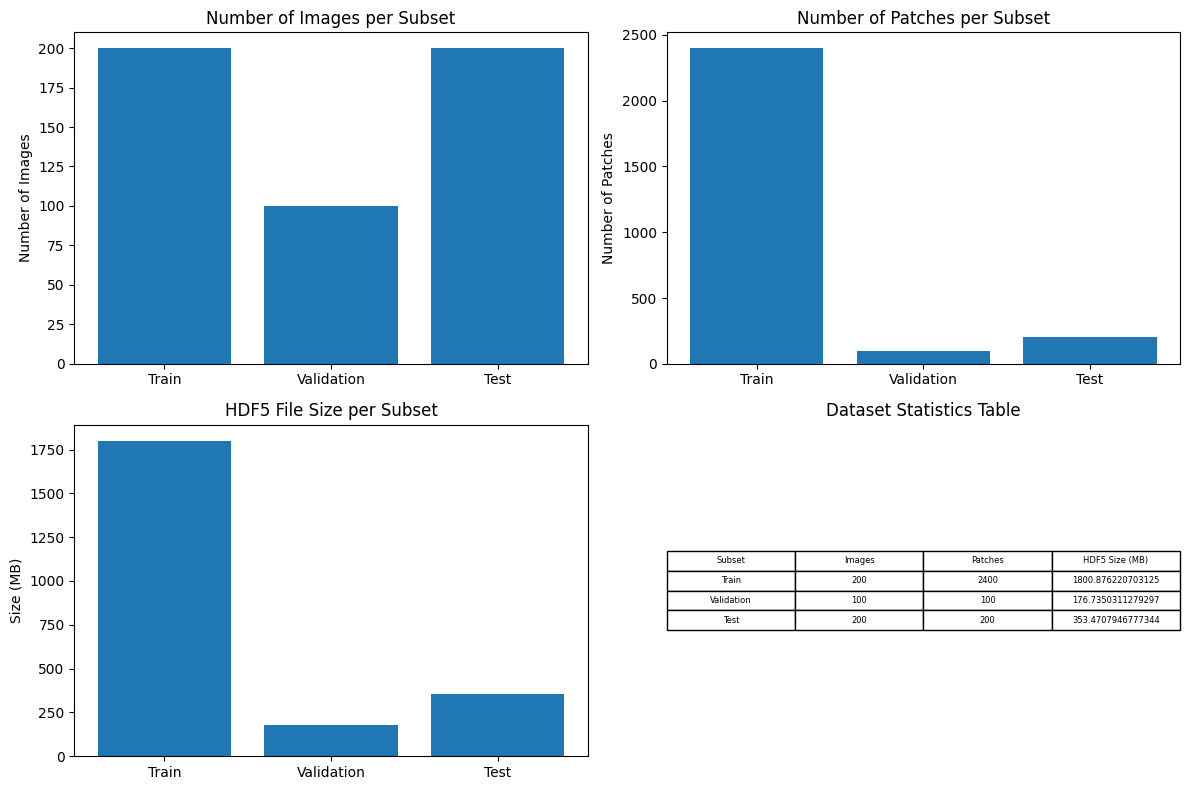


STEP 3: CREATE DATASETS AND LOADERS
Testing data loaders...
Train batch shape: torch.Size([4, 3, 256, 256])
Validation batch shape: torch.Size([4, 3, 256, 256])
Test batch shape: torch.Size([2, 3, 256, 256])

STEP 4: MODEL INITIALIZATION
Model initialized on device: cuda

STEP 5: MODEL TRAINING
Training on device: cuda
  Batch [0/600], Loss: 0.555235
  Batch [50/600], Loss: 0.005162
  Batch [100/600], Loss: 0.003806
  Batch [150/600], Loss: 0.002363
  Batch [200/600], Loss: 0.002861
  Batch [250/600], Loss: 0.001737
  Batch [300/600], Loss: 0.001874
  Batch [350/600], Loss: 0.001473
  Batch [400/600], Loss: 0.002571
  Batch [450/600], Loss: 0.002752
  Batch [500/600], Loss: 0.003369
  Batch [550/600], Loss: 0.002262
Epoch [1/30] (126.20s)
  Train Loss: 0.004628 | Val Loss: 0.002167
  Train PSNR: 25.466 | Val PSNR: 27.280
  Train SSIM: 0.6979 | Val SSIM: 0.7607
  Learning Rate: 1.00e-03
----------------------------------------------------------------------
  Batch [0/600], Loss: 0.0010

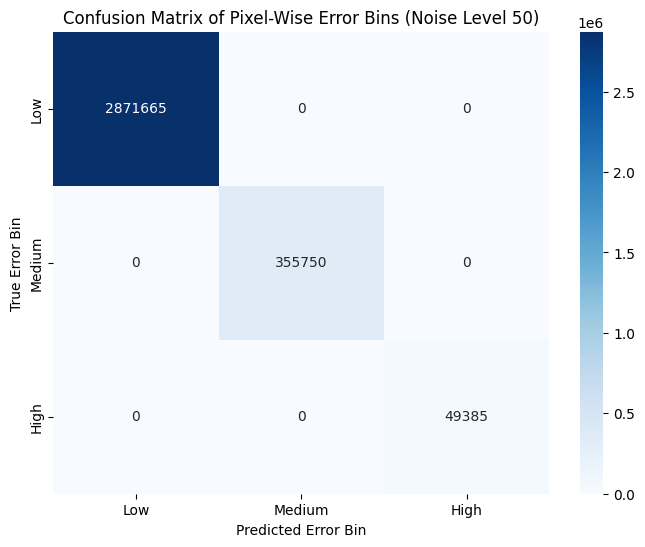

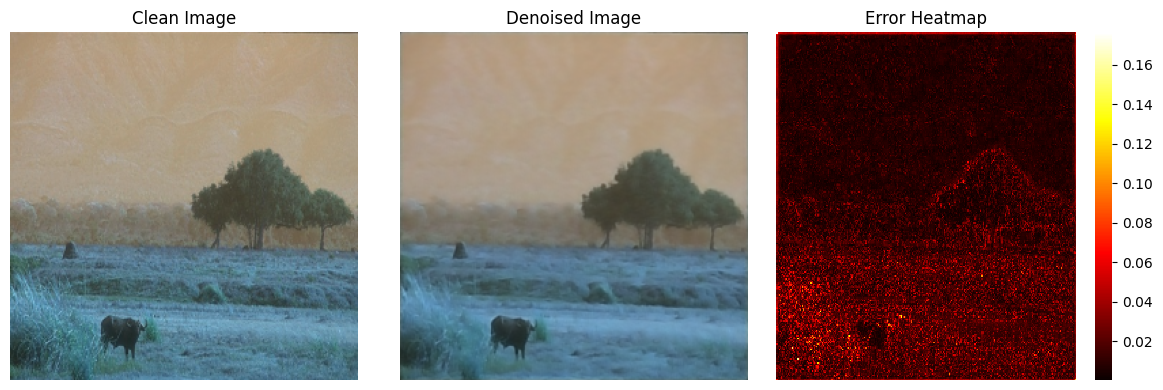


STEP 7: VISUALIZATION


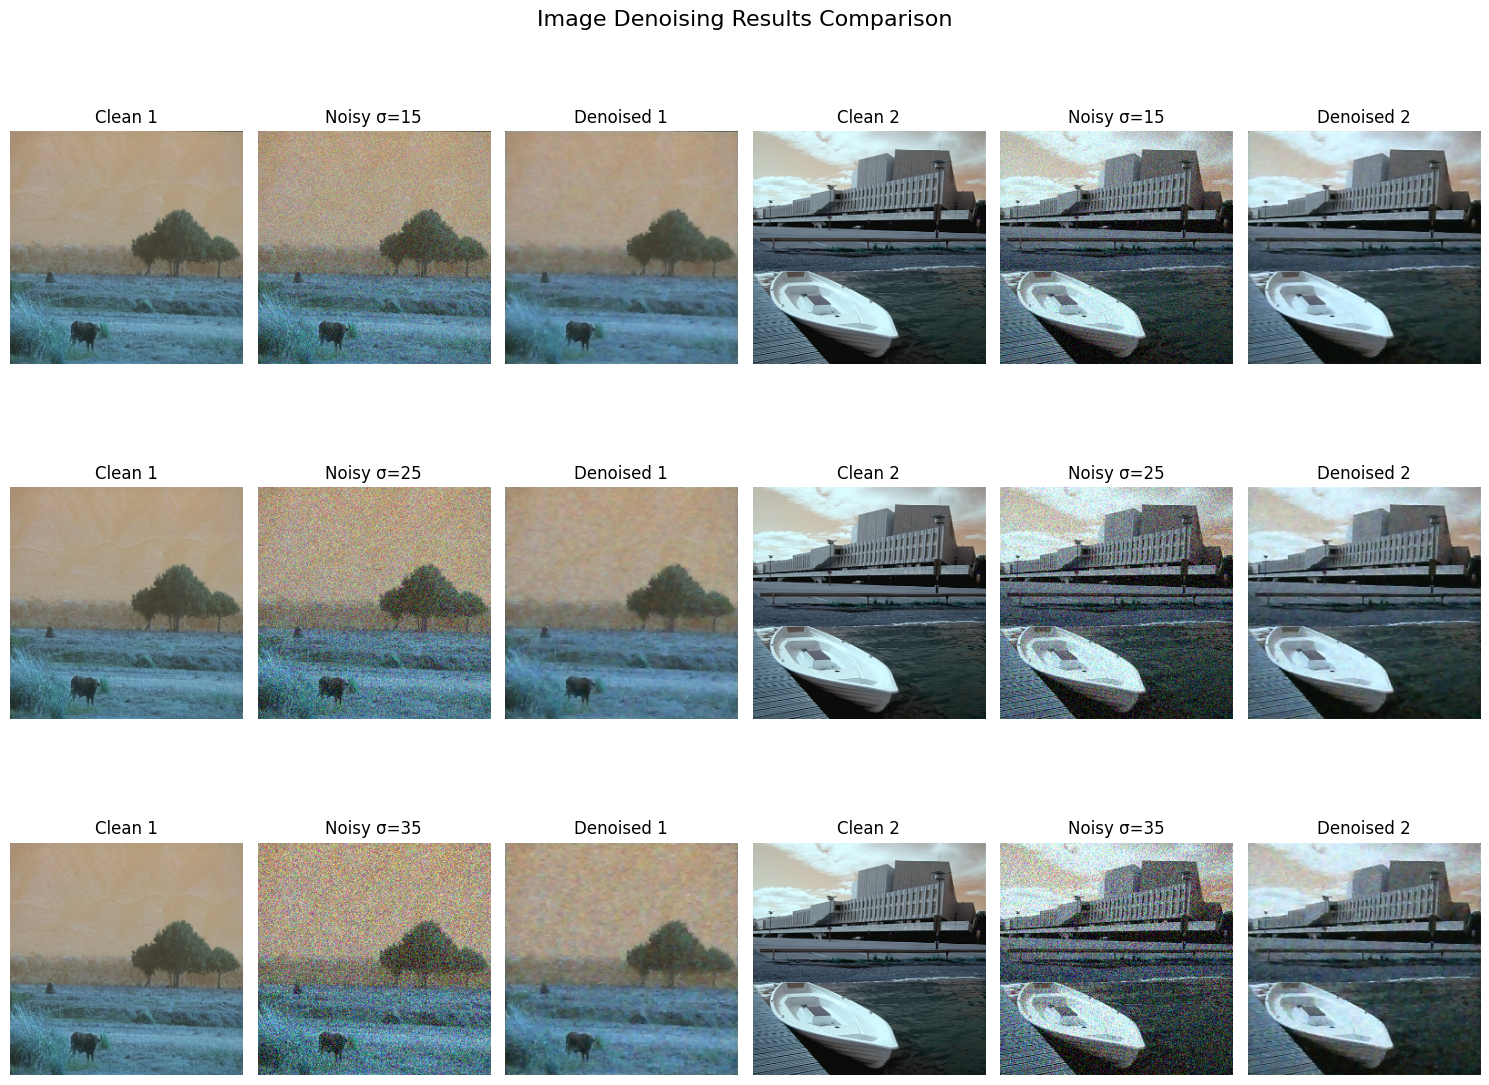


STEP 8: PERFORMANCE ANALYSIS
No valid results to analyze

PIPELINE COMPLETED SUCCESSFULLY


In [11]:
def run_evaluation_pipeline():
    """Run the complete evaluation pipeline with error handling"""
    print("Starting Model Evaluation Pipeline...")

    try:
        # Step 1: Setup environment
        print("\n" + "="*50)
        print("STEP 1: ENVIRONMENT SETUP")
        print("="*50)
        seed_torch()
        print("Environment setup complete!")

        # Step 2: Prepare dataset
        print("\n" + "="*50)
        print("STEP 2: DATASET PREPARATION")
        print("="*50)
        dataset_stats = prepare_data(f'{base_dir}/data', '.', patch_size=256, stride=128, aug_times=2)

        # Step 3: Create datasets and data loaders
        print("\n" + "="*50)
        print("STEP 3: CREATE DATASETS AND LOADERS")
        print("="*50)
        train_dataset = BSRDataset(f'{base_dir}/data', train=True, target_size=256)
        val_dataset = BSRDataset(f'{base_dir}/data', train=False, target_size=256)
        test_dataset = BSRDataset(f'{base_dir}/data', train=False, target_size=256)

        train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
        test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)

        print("Testing data loaders...")
        train_batch = next(iter(train_loader))
        print(f"Train batch shape: {train_batch.shape}")
        val_batch = next(iter(val_loader))
        print(f"Validation batch shape: {val_batch.shape}")
        test_batch = next(iter(test_loader))
        print(f"Test batch shape: {test_batch.shape}")

        # Step 4: Initialize model
        print("\n" + "="*50)
        print("STEP 4: MODEL INITIALIZATION")
        print("="*50)
        model = UNet_Denoiser()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Model initialized on device: {device}")

        # Step 5: Train model
        print("\n" + "="*50)
        print("STEP 5: MODEL TRAINING")
        print("="*50)
        training_history = train_model_fixed(
            model,
            train_loader,
            val_loader,
            num_epochs=30,
            learning_rate=1e-3
        )

        # Step 6: Load best model and run evaluation
        print("\n" + "="*50)
        print("STEP 6: COMPREHENSIVE EVALUATION")
        print("="*50)
        try:
            model.load_state_dict(torch.load(f'{base_dir}/saved_models/best_model.pth', map_location=device))
            print("Loaded best model from checkpoint")
        except:
            print("Using current model (checkpoint not found)")

        evaluation_results = safe_comprehensive_evaluation(model, test_loader, device, max_batches=5)

        # Step 7: Create visualization
        print("\n" + "="*50)
        print("STEP 7: VISUALIZATION")
        print("="*50)
        create_simple_comparison_visualization(model, test_loader, device, num_samples=3)

        # Step 8: Performance analysis
        print("\n" + "="*50)
        print("STEP 8: PERFORMANCE ANALYSIS")
        print("="*50)
        performance_results = create_enhanced_performance_analysis(evaluation_results, training_history)

        print("\n" + "="*50)
        print("PIPELINE COMPLETED SUCCESSFULLY")
        print("="*50)
        return dataset_stats, training_history, evaluation_results, performance_results

    except Exception as e:
        print(f"Error in pipeline: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

# Run the pipeline
if __name__ == "__main__":
    dataset_stats, training_history, evaluation_results, performance_results = run_evaluation_pipeline()


PSNR and SSIM Summary Table
Empty DataFrame
Columns: [Noise Level, PSNR (dB), SSIM]
Index: []
Error creating PSNR and SSIM table: index 0 is out of bounds for axis 0 with size 0


Traceback (most recent call last):
  File "<ipython-input-13-37040e4b96b4>", line 49, in create_psnr_ssim_table
    table = ax.table(
            ^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/table.py", line 761, in table
    cols = len(cellText[0])
               ~~~~~~~~^^^
IndexError: index 0 is out of bounds for axis 0 with size 0


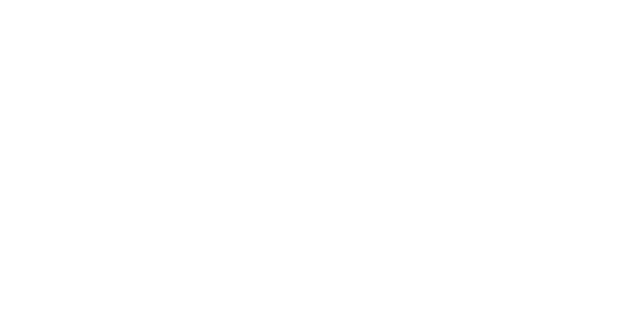

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def create_psnr_ssim_table(evaluation_results, output_dir):
    """Create a table summarizing PSNR and SSIM metrics across noise levels"""
    try:
        if not evaluation_results or 'psnr_scores' not in evaluation_results or 'ssim_scores' not in evaluation_results:
            print("Error: Invalid or missing evaluation results")
            return None

        # Convert results to DataFrame
        df_results = pd.DataFrame(evaluation_results)

        # Define noise levels
        noise_levels = sorted(df_results['noise_levels'].unique())

        # Compute statistics
        table_data = []
        for nl in noise_levels:
            subset = df_results[df_results['noise_levels'] == nl]
            if len(subset) > 0:
                psnr_mean = subset['psnr_scores'].mean()
                psnr_std = subset['psnr_scores'].std()
                ssim_mean = subset['ssim_scores'].mean()
                ssim_std = subset['ssim_scores'].std()
                table_data.append([
                    f'σ={nl}',
                    f"{psnr_mean:.2f} ± {psnr_std:.2f}",
                    f"{ssim_mean:.3f} ± {ssim_std:.3f}"
                ])
            else:
                table_data.append([f'σ={nl}', "N/A", "N/A"])

        # Create DataFrame for table
        table_df = pd.DataFrame(table_data, columns=['Noise Level', 'PSNR (dB)', 'SSIM'])

        # Print table in console
        print("\n" + "="*50)
        print("PSNR and SSIM Summary Table")
        print("="*50)
        print(table_df.to_string(index=False))
        print("="*50)

        # Visualize table
        plt.figure(figsize=(8, 4))
        ax = plt.gca()
        ax.axis('off')
        table = ax.table(
            cellText=table_df.values,
            colLabels=table_df.columns,
            cellLoc='center',
            loc='center',
            colColours=['#f0f0f0']*3,
            cellColours=[['#ffffff']*3]*len(table_df)
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.5)
        plt.title('PSNR and SSIM by Noise Level', fontsize=12, pad=20)

        # Save table as image
        try:
            plt.savefig(f'{output_dir}/psnr_ssim_table.png', dpi=300, bbox_inches='tight')
            plt.show()
        except Exception as e:
            print(f"Warning: Could not save table image: {e}")
            plt.show()

        return table_df

    except Exception as e:
        print(f"Error creating PSNR and SSIM table: {e}")
        import traceback
        traceback.print_exc()
        return None

# Generate the table using evaluation results
table_df = create_psnr_ssim_table(evaluation_results, f'{base_dir}/output')